<a href="https://colab.research.google.com/github/HarshilShah1804/ES335_Assignment_3/blob/main/ML_model_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import csv

X, y = [], []

with open('dataset_holmes_15.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        X.append([int(value) for value in row[:-1]])
        y.append(int(row[-1]))

In [ ]:
len(X[0])

15

In [ ]:
X = torch.tensor(X).to(device)
Y = torch.tensor(y).to(device)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([235571, 15]), torch.int64, torch.Size([235571]), torch.int64)

In [ ]:
itos = {}

# Open the CSV file and read the content
with open('tokens_holmes.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        # Assuming row[0] is the ID and row[1] is the token
        token_id = int(row[1])  # Convert ID to integer
        token = row[0]  # Token remains as a string
        itos[token_id] = token  # Map ID to token

In [ ]:
emb_dim = 64
emb = torch.nn.Embedding(len(itos), emb_dim)

In [ ]:
emb.weight.shape

torch.Size([8498, 64])

In [ ]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, 512)
    self.lin3 = nn.Linear(512, 256)
    self.lin4 = nn.Linear(256, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.tanh(self.lin1(x))
    x = torch.tanh(self.lin2(x))
    x = torch.tanh(self.lin3(x))
    x = self.lin4(x)
    return x

In [ ]:
model = NextChar(15, len(itos), emb_dim, 1024).to(device)

In [ ]:
def generate_name(model, itos, block_size, max_len=10):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        if ch == '' and name != '':
            break
        name += ch
        context = context[1:] + [ix]
    return name

print(generate_name(model, itos, 15, 200))

serieshailhowpretendsuncouthladderWatergenerationoccurrencesrelationsnailsweatdeathaddingrelieveproportionwormbosomraisedconvenientlydeskcloudsbondwhipcollapsecirculationcrowddyingkilledsheetworkmenFreemasonrylaneprecededupstairsLtappedhencerevealingtoldvilestrejoicedresortsparklesNameobviousoppressivelyreapedsnufflectureanatomyMarketglarecommunication8delderlyDearfriendlyhoaxdidExcuseeagerinadequatebloodygiveninvitedthreatenedstoryAngelJoneseversnarledAmericanconversationparcelcushionedthenoilystrangerwatchedwiselysharereplyWilsongreatestAlreadywhisperorphanageroom7exaggeratedquesthingesprovidedpurchasetripstormyfilialclaspingdefectbuzzhastilydingyyearsBowrelicprofessionredTheyEnglishnonentitymysteriousSpiesArtillerypiercedflowerslegaltreadwallchiselidleConfederatesolicitorstrivingansweredHyde12sbetrothalwalklatelyterrifiedsmarterimplicatedEachimmenseApachesbrokebloodstainsarrowsboxerworryAberdeenEvidentlyappealssurpriseluridnearlysniggeraskedDukeforgeryreasonedinspectorreceiveddeclar

In [ ]:
# Train the model

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)

# Mini-batch training
batch_size = int(X.shape[0]/100)
print_every = 5
min_loss = float('inf')
for epoch in range(1000):
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    if(float(loss.item()) < min_loss):
        #save the weights
        torch.save(model.state_dict(), 'holmes_15_64_tanh.pt')
        min_loss = float(loss.item())
        print(epoch, loss.item())
        print("\n\n\n")
    if epoch % print_every == 0:
        print(epoch, loss.item())
        print("---------")
        print(generate_name(model, itos, 15, 200))
        print("---------")
        print("\n\n\n")

0 4.6809163093566895




0 4.6809163093566895
---------
I
---------




1 3.9717154502868652




2 3.6264524459838867




4 3.5198569297790527




5 3.6926660537719727
---------
“‘Oh’. I you find chemical a stair the lady, key the a my when the to me, surprised’doors do, I and advance my, that fortnight with linen door her from man, and nonentity think, Mrs, dim, anteroom, could, I astonished. Well, minutes I as dearest a all Alice back’what’
---------




6 3.43302845954895




8 3.3988049030303955




9 3.396484613418579




10 3.3333683013916016




10 3.3333683013916016
---------
“It I we and set, want,’ we said fortunately has my chance I think, I were that she then a room, her, and of a soon and might locked. I and now rushed enough myself’s, were a lady shall of Mr, have she of bills, bands no comfortable recompense should on fulfilled as I was to there should as and destitute we and the man inwindowswife Place at and. cried you through her man is shone with on upon of that foll

In [ ]:
min_loss

In [ ]:
# print(generate_name(model, itos, 10, 20))
print(generate_name(model, itos, 15, 25))

“I should like certainly see difficulty as that this other eyes.


In [ ]:
model.load_state_dict(torch.load('holmes_15_64_tanh.pt'))

<ipython-input-15-8276cf1bf498>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('holmes_15_64_tanh.pt'))


<All keys matched successfully>

In [ ]:
stoi = {}

# Open the CSV file and read the content
with open('tokens_holmes.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        # Assuming row[0] is the ID and row[1] is the token
        token_id = row[0]  # Convert ID to integer
        token = int(row[1])  # Token remains as a string
        stoi[token_id] = token  # Map ID to token

In [ ]:
import re

def tokenize_code(data):
    pattern = r"(\b\w+\b|\d+|[^\w\s]|\s+)"
    tokens = re.findall(pattern, data)

    return tokens

def generate_from_prompt(prompt, model, itos, stoi, block_size, max_len=10):
    context = [0] * block_size
    name = prompt
    for ch in tokenize_code(prompt):
        if ch not in stoi:
            context = context[1:] + [1]
            continue
        ix = stoi[ch]
        context = context[1:] + [ix]


    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        if ch == '' and name != '':
            break
        name += ch
        context = context[1:] + [ix]
    return name

In [ ]:
generate_from_prompt('hello Holmes you ', model, itos, stoi, 15, 200)

'hello Holmes you know not be worth. And I must try so imagine,’   of the Alpha, sir, slipped to Philadelphia. Now. With caused the original breakfast fashion from the hall work was the German and were as in this in the morning, and he met twenty over up to play.'

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


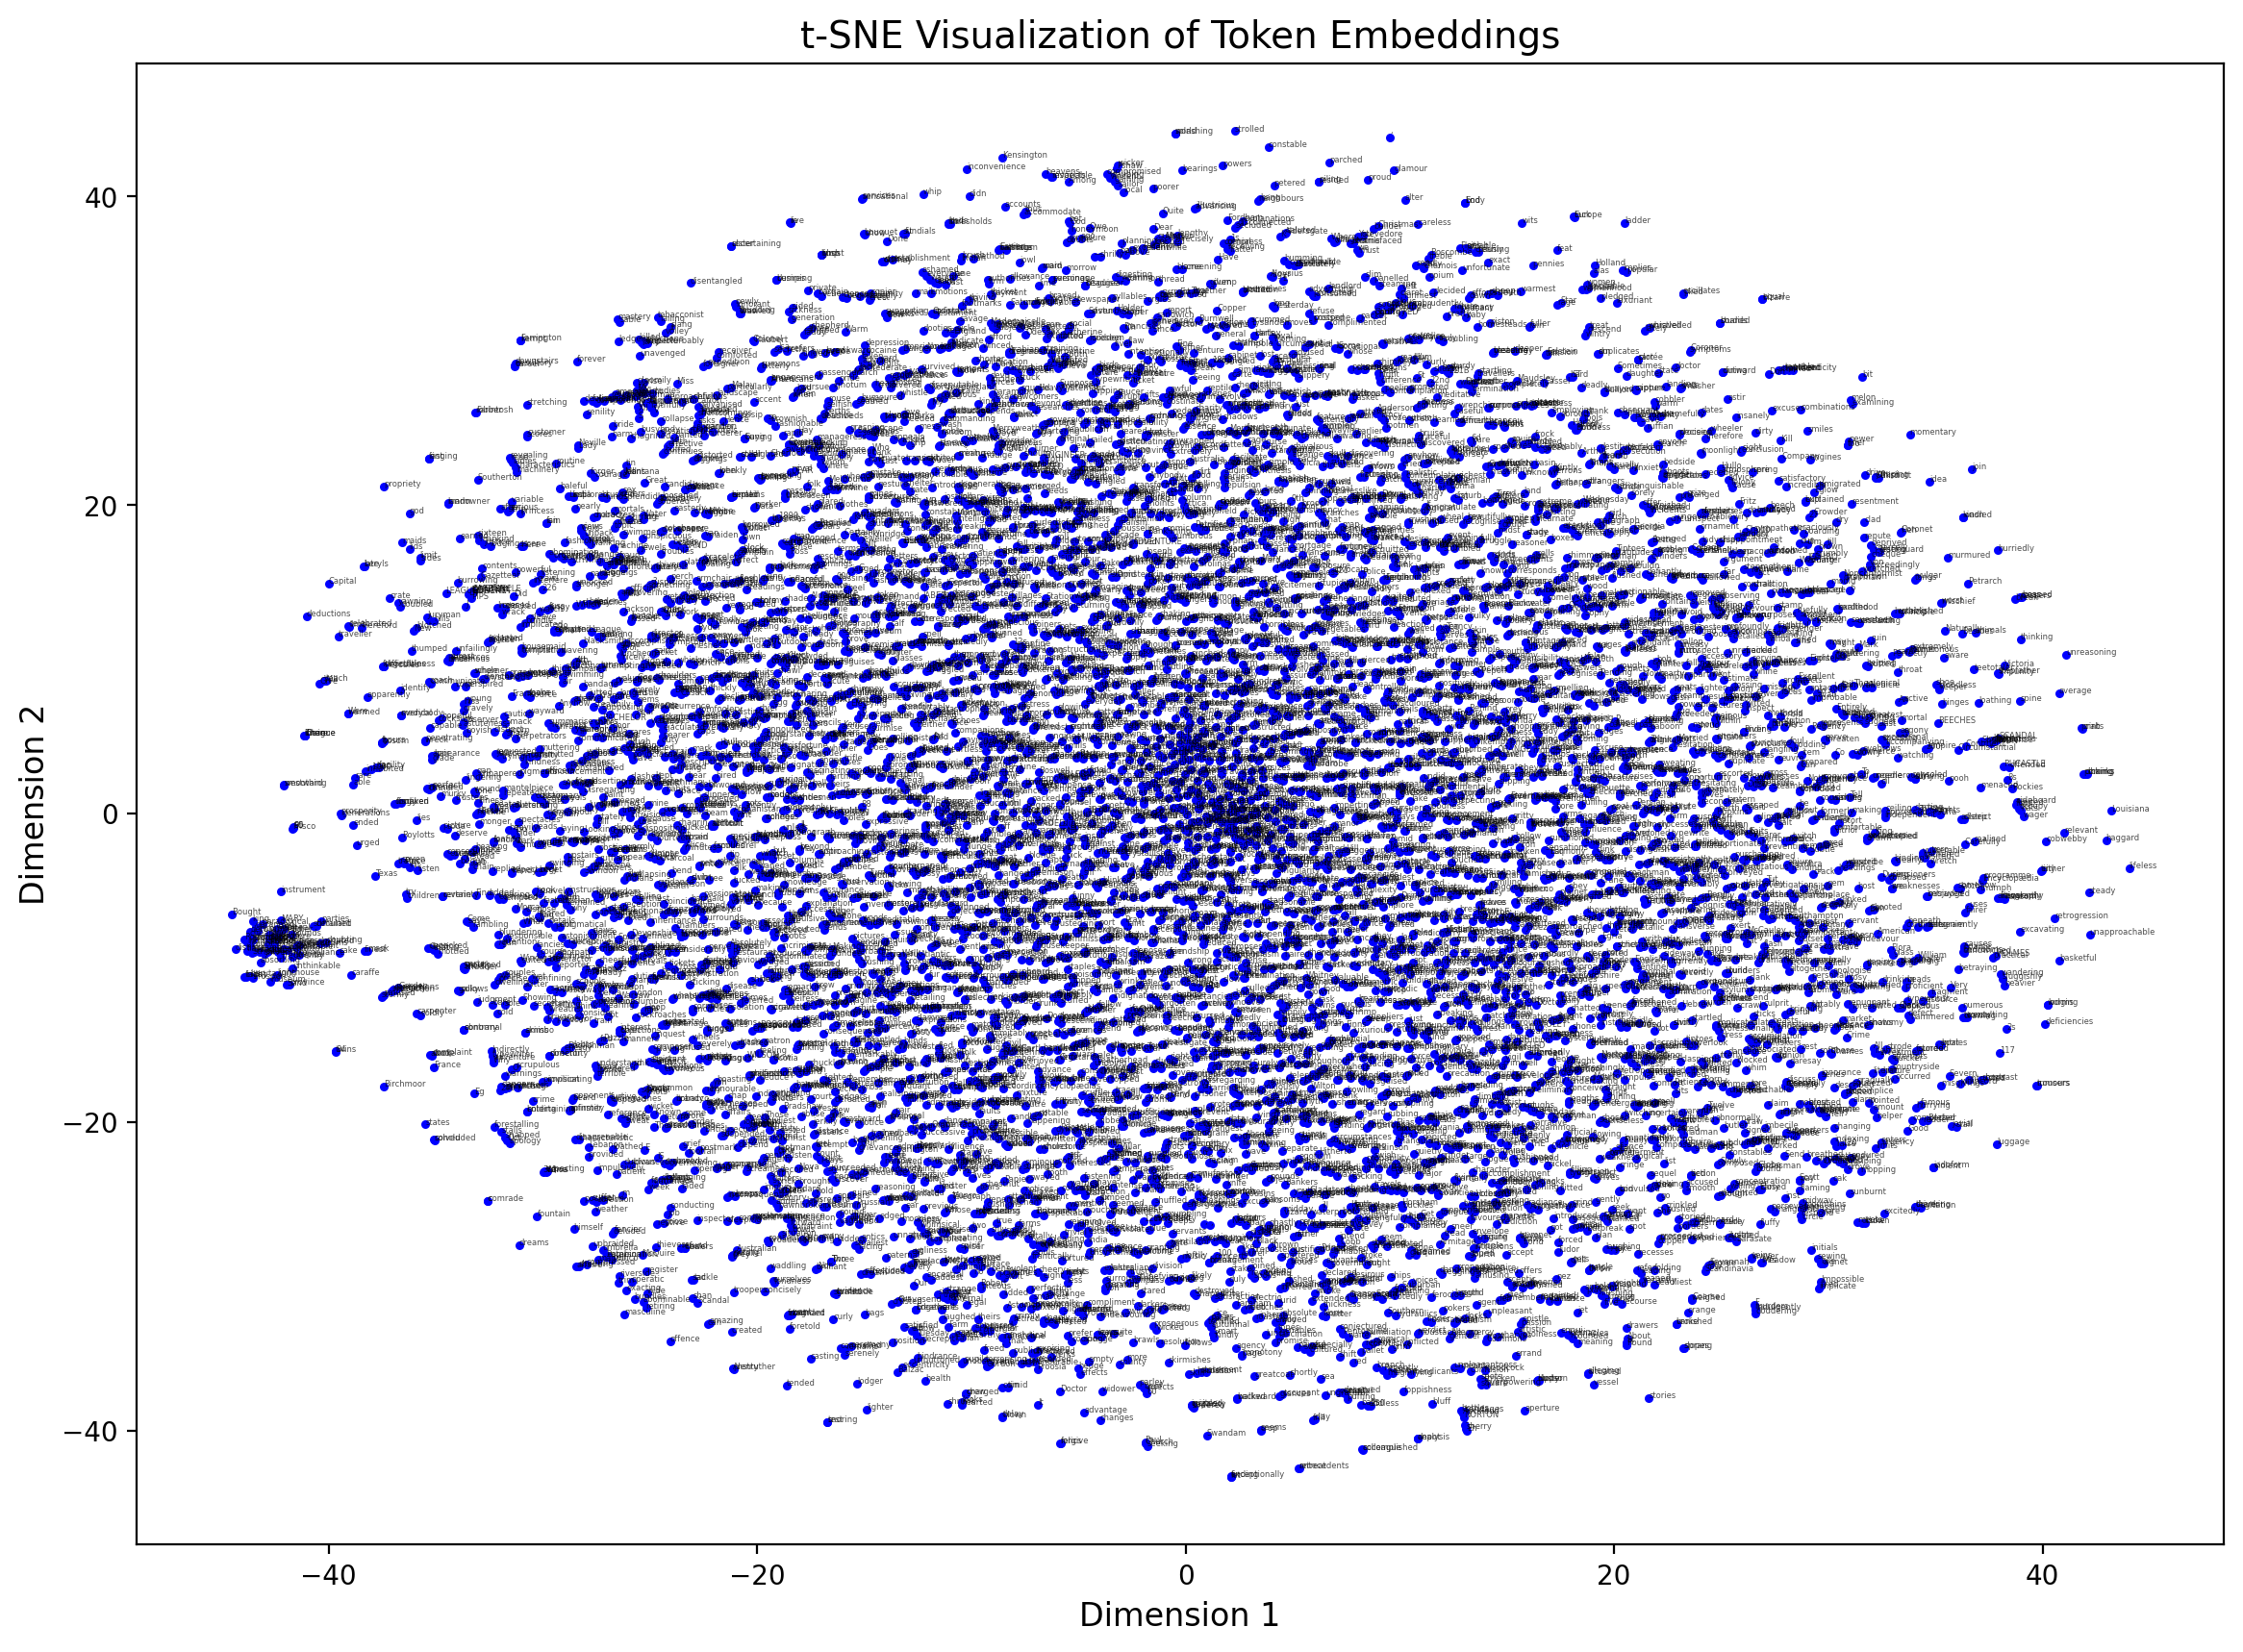

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

# Extract embeddings from the trained model
embedding_matrix = model.emb.weight.detach().cpu().numpy()

# Apply t-SNE to reduce the embeddings to 2 dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embedding_2d = tsne.fit_transform(embedding_matrix)

# Plot the 2D scatter plot of the embeddings
plt.figure(figsize=(14, 10))
for i, token_id in enumerate(itos):
    x, y = embedding_2d[i, 0], embedding_2d[i, 1]
    plt.scatter(x, y, color='blue', s=5)  # Reduce marker size to s=10
    plt.text(x, y, itos[token_id], fontsize=3, alpha=0.7)  # Smaller text and transparency

plt.title("t-SNE Visualization of Token Embeddings", fontsize=14)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.show()
